# scGPT Zero-Shot Reference & Query Embedding

## Introduction
This notebook covers visualisation of scGPT embeddings generated using [Ramachandran dataset](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE136103) as query and [MacParland dataset](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE115469) as reference. The aim of this notebook is to explore the use of scGPT for annotating unknown cell labels in the endothelial zone of human liver.

This notebook is based off the [scGPT GitHub tutorial](https://github.com/bowang-lab/scGPT/blob/main/tutorials/zero-shot/Tutorial_ZeroShot_Reference_Mapping.ipynb/).

## Step 1: Install and Imports

Install the following versions of scgpt, torch and numpy in order to correctly install scgpt.

In [ ]:
# --- Installs ---

!pip install -U -q scgpt "torch<=2.2.2" "numpy<2" "umap-learn<0.5.7"
!pip install -q wandb louvain faiss-cpu
!pip install -q scanpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.7/831.7 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 69.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Restart your runtime before continuing with the next cell

In [ ]:
import scgpt as scg
print("scGPT loaded successfully!", scg.__version__)

/usr/local/lib/python3.12/dist-packages/scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/usr/local/lib/python3.12/dist-packages/scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")


scGPT loaded successfully! 0.2.4


In [ ]:
# --- Imports ---

import scanpy as sc
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import warnings
from scipy.stats import mode
from pathlib import Path
import anndata as ad

# extra dependency for similarity search
try:
    import faiss

    faiss_imported = True
    print("faiss imported!")
    print(faiss.__version__)

except ImportError:
    faiss_imported = False
    print(
        "faiss not installed! We highly recommend installing it for fast similarity search."
    )
    print("To install it, see https://github.com/facebookresearch/faiss/wiki/Installing-Faiss")

warnings.filterwarnings("ignore", category=ResourceWarning)
warnings.filterwarnings("ignore", category=ImportWarning)

faiss imported!
1.12.0


## Step 2: Load data

Using ScanPy, load the data and create AnnData objects. The format should be H5AD, and the data should be in raw count matrix. If you are using two datasets (reference and query), make sure both datasets have common genes. Add cell annotations for your reference dataset, and also for query if you have them.

In this notebook, a combined dataset consisting of healthy samples from the Ramachandran dataset is being used as the Query, and the MacParland dataset is being used as the Reference.

In [ ]:
# --- Load data ---

query_adata = sc.read_h5ad("/content/drive/MyDrive/projects/scGPT-MAFLD/data/healthy_samples.h5ad")
ref_adata = sc.read_h5ad("/content/drive/MyDrive/projects/scGPT-MAFLD/data/MacParland.h5ad")

# Load the cell annotation file
labels = pd.read_csv(
    "/content/drive/MyDrive/projects/scGPT-MAFLD/data/GSE115469_CellClusterType.txt",
    sep="\t",
    index_col=0
)

/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [ ]:
# --- Add cell annotations to ref_adata ---

# Fix reference cell names to match annotation
ref_adata.obs_names = ref_adata.obs_names.str.replace("^Nash_", "", regex=True)

# Find common cells between reference and annotation
common_cells = ref_adata.obs_names.intersection(labels.index)
print(f"Number of matching cells: {len(common_cells)}")

# Subset reference to only those cells and add true labels
ref_adata = ref_adata[common_cells, :].copy()
ref_adata.obs['celltype_true'] = labels.loc[ref_adata.obs_names, 'CellType']

# Verify
print(ref_adata.obs[['celltype_true']].head())

Number of matching cells: 8310
                                        celltype_true
P1TLH_AAACCTGAGCAGCCTC_1         Central_venous_LSECs
P1TLH_AAACCTGTCCTCATTA_1               Cholangiocytes
P1TLH_AAACCTGTCTAAGCCA_1         Central_venous_LSECs
P1TLH_AAACGGGAGTAGGCCA_1  Non-inflammatory_Macrophage
P1TLH_AAACGGGGTTCGGGCT_1           alpha-beta_T_Cells


In [ ]:
print(ref_adata)

AnnData object with n_obs × n_vars = 8310 × 1500
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'celltype_true'
    var: 'vf_vst_counts_mean', 'vf_vst_counts_variance', 'vf_vst_counts_variance.expected', 'vf_vst_counts_variance.standardized', 'vf_vst_counts_variable', 'vf_vst_counts_rank', 'var.features', 'var.features.rank'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'


In [ ]:
print(query_adata)

AnnData object with n_obs × n_vars = 28306 × 17934
    obs: 'sample_id', 'batch', 'group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'gene_symbols', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'


### Find common genes between reference and query datasets

In [ ]:
# Set var_names to gene_symbols, but make sure they're strings
query_adata.var_names = query_adata.var["gene_symbols"].astype(str)

# Drop duplicates (keep the first occurrence)
query_adata = query_adata[:, ~query_adata.var_names.duplicated()].copy()

/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [ ]:
# Find common genes
common_genes = ref_adata.var_names.intersection(query_adata.var_names)
print(f"Number of common genes: {len(common_genes)}")

# Subset both to common genes
ref_adata = ref_adata[:, common_genes].copy()
query_adata = query_adata[:, common_genes].copy()

Number of common genes: 1096


In [ ]:
assert all(ref_adata.var_names == query_adata.var_names)

In [ ]:
ref_adata

AnnData object with n_obs × n_vars = 8310 × 1096
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'celltype_true'
    var: 'vf_vst_counts_mean', 'vf_vst_counts_variance', 'vf_vst_counts_variance.expected', 'vf_vst_counts_variance.standardized', 'vf_vst_counts_variable', 'vf_vst_counts_rank', 'var.features', 'var.features.rank'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [ ]:
query_adata

AnnData object with n_obs × n_vars = 28306 × 1096
    obs: 'sample_id', 'batch', 'group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'gene_symbols', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

## Step 3: Generate Embeddings on Reference and Query datasets

Download the scGPT model files from here. Set a model directory and generate embeddings. Make sure you set the correct gene column name, this can be found under 'var' in your AnnData object.

In [ ]:
# Set model directory
model_dir = "/content/drive/MyDrive/projects/scGPT-MAFLD/scGPT_human/"

In [ ]:
# --- Generate query embeddings ---

%%time

# Set gene column
gene_col = "gene_symbols"

# Generate embeddings
query_embed_adata = scg.tasks.embed_data(
    query_adata,
    model_dir,
    gene_col=gene_col,
    device="cuda",
    use_fast_transformer=False,
)

scGPT - INFO - match 997/1096 genes in vocabulary of size 60697.


Embedding cells: 100%|██████████| 443/443 [00:16<00:00, 27.56it/s]


CPU times: user 11.1 s, sys: 792 ms, total: 11.9 s
Wall time: 17.6 s


/usr/local/lib/python3.12/dist-packages/scgpt/tasks/cell_emb.py:279: ImplicitModificationWarning: Setting element `.obsm['X_scGPT']` of view, initializing view as actual.
  adata.obsm["X_scGPT"] = cell_embeddings
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [ ]:
# --- Generate reference embeddings ---

%%time

# Set gene column
gene_col = "var.features"

# Generate embeddings
ref_embed_adata = scg.tasks.embed_data(
    ref_adata,
    model_dir,
    gene_col=gene_col,
    device="cuda",
    use_fast_transformer=False,
)

scGPT - INFO - match 997/1096 genes in vocabulary of size 60697.


Embedding cells: 100%|██████████| 130/130 [00:58<00:00,  2.22it/s]
/usr/local/lib/python3.12/dist-packages/scgpt/tasks/cell_emb.py:279: ImplicitModificationWarning: Setting element `.obsm['X_scGPT']` of view, initializing view as actual.
  adata.obsm["X_scGPT"] = cell_embeddings


CPU times: user 57 s, sys: 677 ms, total: 57.7 s
Wall time: 60 s


In [ ]:
query_embed_adata

AnnData object with n_obs × n_vars = 28306 × 997
    obs: 'sample_id', 'batch', 'group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'gene_symbols', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'id_in_vocab'
    obsm: 'X_scGPT'

## Step 4: Visualise the Embeddings

Concatenate the embeddings to visualise them on a UMAP.

In [ ]:
# Column in reference to use as cell type labels
cell_type_key = "celltype_true"

# Make observation names unique to avoid warnings
query_embed_adata.obs_names_make_unique()
ref_embed_adata.obs_names_make_unique()

# Concatenate datasets (inner join keeps only shared genes)
adata_concat = ad.concat(
    [query_embed_adata, ref_embed_adata],
    join="inner",
    label="dataset",
    keys=["query", "ref"]
)

# Add is_ref column
adata_concat.obs["is_ref"] = ["Query" if x == "query" else "Reference" for x in adata_concat.obs["dataset"]]

# Initialize cell type column if missing
if cell_type_key not in adata_concat.obs.columns:
    adata_concat.obs[cell_type_key] = pd.Categorical(["To be predicted"] * adata_concat.n_obs)

# Ensure the column is categorical
adata_concat.obs[cell_type_key] = adata_concat.obs[cell_type_key].astype("category")

# Add "To be predicted" category if it doesn't already exist
if "To be predicted" not in adata_concat.obs[cell_type_key].cat.categories:
    adata_concat.obs[cell_type_key] = adata_concat.obs[cell_type_key].cat.add_categories(["To be predicted"])

# Mask the query dataset cell types
adata_concat.obs[cell_type_key][:len(query_embed_adata)] = "To be predicted"

/tmp/ipython-input-2688149806.py:9: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  adata_concat = ad.concat(
/tmp/ipython-input-2688149806.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

In [ ]:
# saving concatenated files for post-processing UMAPs
adata_concat.write('/content/drive/MyDrive/projects/scGPT-MAFLD/data/ramachandran_embed_concat.h5ad')

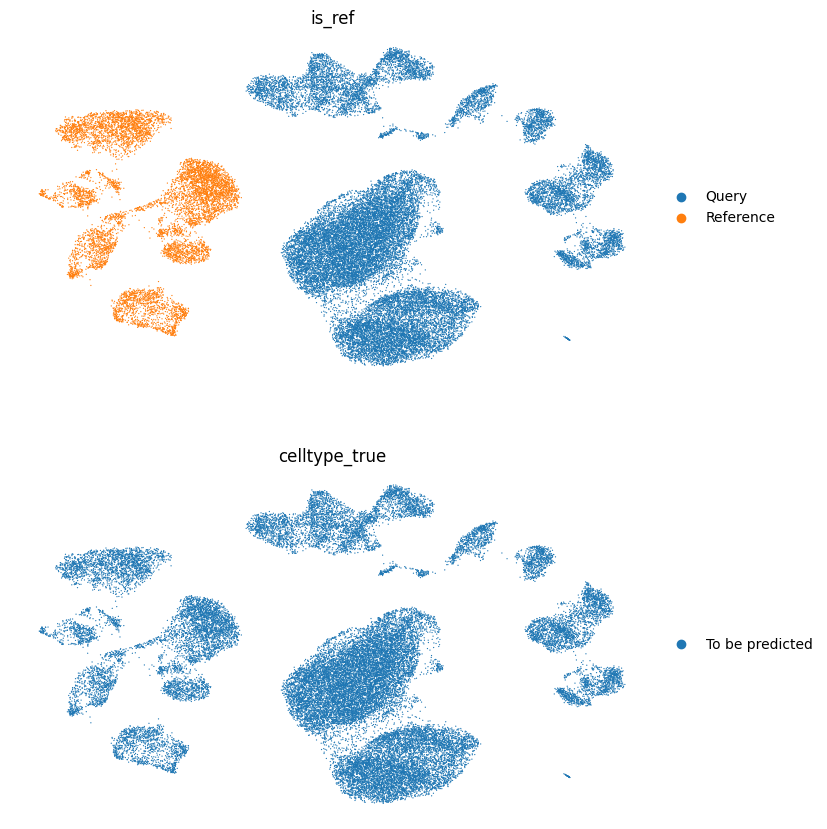

In [ ]:
sc.pp.neighbors(adata_concat, use_rep="X_scGPT")
sc.tl.umap(adata_concat)
sc.pl.umap(
    adata_concat,
    color=["is_ref", cell_type_key],
    wspace=0.4,
    frameon=False,
    ncols=1,
    show=False
)

plt.savefig("/content/drive/MyDrive/projects/scGPT-MAFLD/plots/ramachandran_embed_umap.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

## Trial with Cirrhotic samples as Query

In [ ]:
# --- Load data ---

query_adata = sc.read_h5ad("/content/drive/MyDrive/projects/scGPT-MAFLD/data/cirrhotic_samples.h5ad")
ref_adata = sc.read_h5ad("/content/drive/MyDrive/projects/scGPT-MAFLD/data/healthy_samples.h5ad")

/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [ ]:
query_adata

AnnData object with n_obs × n_vars = 19605 × 18916
    obs: 'sample_id', 'batch', 'group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'gene_symbols', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

In [ ]:
ref_adata

AnnData object with n_obs × n_vars = 28306 × 17934
    obs: 'sample_id', 'batch', 'group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'gene_symbols', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

In [ ]:
# Set var_names to gene_symbols, but make sure they're strings
query_adata.var_names = query_adata.var["gene_symbols"].astype(str)

# Drop duplicates (keep the first occurrence)
query_adata = query_adata[:, ~query_adata.var_names.duplicated()].copy()

/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [ ]:
# Find common genes
common_genes = ref_adata.var_names.intersection(query_adata.var_names)
print(f"Number of common genes: {len(common_genes)}")

# Subset both to common genes
ref_adata = ref_adata[:, common_genes].copy()
query_adata = query_adata[:, common_genes].copy()

Number of common genes: 0
